In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support as score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [2]:
raw_data = pd.read_csv('data/data_science_assignment_data.csv')

In [3]:
raw_data.head()

,date,numeric0,numeric1,categorical0,time,target
0,2015-11-24,2515,2.0,c,01:33:52,0
1,2009-03-05,5156,NaN,b,20:09:27,0
2,2015-12-23,5930,NaN,b,11:22:35,0
3,1992-02-16,2967,NaN,b,19:18:36,0
4,1971-06-06,194,5.0,c,20:01:58,0


In [4]:
raw_data.dtypes

date             object
numeric0          int64
numeric1        float64
categorical0     object
time             object
target            int64
dtype: object

In [5]:
print(f"Number of samples is {raw_data.shape[0]}")

Number of samples is 10000


# General approach to modeling

1. Cleaning data (duplicates, missing values, etc.)
2. Basic features extraction
3. Baseline model
4. Deeper data analysis
5. Attempting to beat baseline model

## 1. Cleaning data

In [6]:
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.date + pd.to_timedelta(raw_data.time)
raw_data.sort_values('date', inplace=True)
raw_data.reset_index(drop=True, inplace=True)

In [7]:
raw_data.head(10)

,date,numeric0,numeric1,categorical0,time,target
0,1970-01-01,7382,NaN,c,13:13:57,0
1,1970-01-02,192,6.0,b,23:37:45,0
2,1970-01-05,4291,NaN,b,22:39:45,0
3,1970-01-06,9735,NaN,c,22:57:37,0
4,1970-01-06,4226,5.0,a,02:13:50,0
5,1970-01-08,5560,NaN,a,02:15:10,0
6,1970-01-10,4821,1.0,a,16:56:20,1
7,1970-01-12,762,7.0,b,11:14:22,1
8,1970-01-14,3942,6.0,a,12:40:03,0
9,1970-01-19,8473,7.0,a,11:20:20,1


It seems that our data consists of time-series part. Let's check how sparse is time-series

In [8]:
whole_dt_range = pd.date_range(start=str(raw_data.date.min().date()), end=str(raw_data.date.max().date()))
unique_dates = raw_data.date.unique()

In [9]:
print(f"Complete time-series consists of {len(whole_dt_range)} dates. Our data has {len(unique_dates)} samples")

Complete time-series consists of 18133 dates. Our data has 7664 samples


Our data is too sparse for time-series modelling approach. But we should consider this time-series component in validation and feature engineering

In [10]:
raw_data.isnull().sum() / raw_data.shape[0]

date            0.0000
numeric0        0.0000
numeric1        0.4917
categorical0    0.0000
time            0.0000
target          0.0000
dtype: float64

Near half of our observations are having missing value for 'numeric1' column. <br> Let's look at this feature values

In [11]:
raw_data.numeric1.unique()

array([nan,  6.,  5.,  1.,  7.,  8.,  3.,  0.,  9.,  2.,  4.])

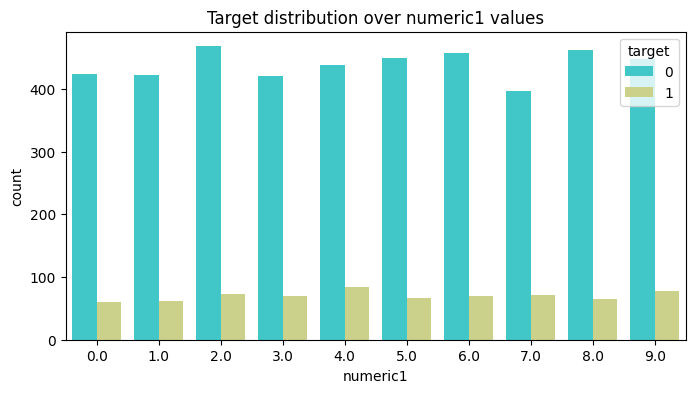

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='numeric1',data=raw_data, palette='rainbow',hue='target')
plt.title("Target distribution over numeric1 values")
plt.show()

In [13]:
_tmp = raw_data.copy()
_tmp['numeric1'] = _tmp.numeric1.astype(str).fillna('NaN') 
_tmp1 = _tmp.groupby(['numeric1', 'target'])[['date']].count().reset_index().rename(columns={'date': 'cnt_target'})
_tmp2 = _tmp.groupby(['numeric1'])[['date']].count().reset_index().rename(columns={'date': 'cnt_numeric1'})
_merged = pd.merge(_tmp1, _tmp2, how='left', on='numeric1')
_merged['percentage'] = _merged['cnt_target'] / _merged['cnt_numeric1']
_merged.drop(['cnt_target', 'cnt_numeric1'], axis=1, inplace=True)
_merged.set_index(['numeric1', 'target'], inplace=True)

In [14]:
_merged

percentage
numeric1 target            
0.0      0         0.876033
         1         0.123967
1.0      0         0.873967
         1         0.126033
2.0      0         0.865065
         1         0.134935
3.0      0         0.859184
         1         0.140816
4.0      0         0.839080
         1         0.160920
5.0      0         0.870155
         1         0.129845
6.0      0         0.868821
         1         0.131179
7.0      0         0.848291
         1         0.151709
8.0      0         0.876660
         1         0.123340
9.0      0         0.853333
         1         0.146667
nan      0         0.871060
         1         0.128940

We can see that 'numeric1' column is categorical feature. Distributions of 'target' values are quite the same among all categories. We can treat missing values with new category - 'nan'

In [15]:
raw_data['numeric1'] = raw_data.numeric1.astype(str).fillna('NaN')

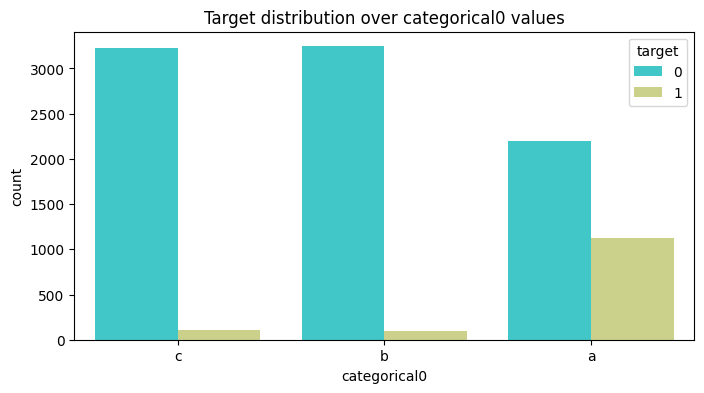

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x='categorical0',data=raw_data, palette='rainbow',hue='target')
plt.title("Target distribution over categorical0 values")
plt.show()

We can see that over 90% of target=1 values are falling into the 'a' value of categorical0 feature. This feature may give us significant increase in model quality

In [17]:
raw_data.head()

,date,numeric0,numeric1,categorical0,time,target
0,1970-01-01,7382,nan,c,13:13:57,0
1,1970-01-02,192,6.0,b,23:37:45,0
2,1970-01-05,4291,nan,b,22:39:45,0
3,1970-01-06,9735,nan,c,22:57:37,0
4,1970-01-06,4226,5.0,a,02:13:50,0


In [18]:
raw_data.drop_duplicates().shape

(10000, 6)

Our data doesn't have any duplicates. <br> At this point we completed basic data cleaning. <br> Let's move on to basic feature generation

## 2. Basic feature generation

In [19]:
clean_data = raw_data.copy()
clean_data["dttm"] = clean_data.date + pd.to_timedelta(clean_data.time)
clean_data.sort_values("dttm", inplace=True)
clean_data.reset_index(drop=True, inplace=True)
clean_data.drop(['date', 'time'], axis=1, inplace=True)

In [20]:
clean_data.head()

,numeric0,numeric1,categorical0,target,dttm
0,7382,nan,c,0,1970-01-01 13:13:57
1,192,6.0,b,0,1970-01-02 23:37:45
2,4291,nan,b,0,1970-01-05 22:39:45
3,4226,5.0,a,0,1970-01-06 02:13:50
4,9735,nan,c,0,1970-01-06 22:57:37


Extract time related features

In [21]:
clean_data["month"] = clean_data.dttm.dt.month
clean_data["day_of_week"] = clean_data.dttm.dt.day_of_week
clean_data["hour"] = clean_data.dttm.dt.hour

clean_data.set_index("dttm", inplace=True)
clean_data = clean_data[["month", "day_of_week", "hour", "numeric0", "numeric1", "categorical0", "target"]]

In [22]:
clean_data.head()

,month,day_of_week,hour,numeric0,numeric1,categorical0,target
dttm,,,,,,,
1970-01-01 13:13:57,1,3,13,7382,nan,c,0
1970-01-02 23:37:45,1,4,23,192,6.0,b,0
1970-01-05 22:39:45,1,0,22,4291,nan,b,0
1970-01-06 02:13:50,1,1,2,4226,5.0,a,0
1970-01-06 22:57:37,1,1,22,9735,nan,c,0


Take a closer look at the only real numerical feature we have - numeric0 

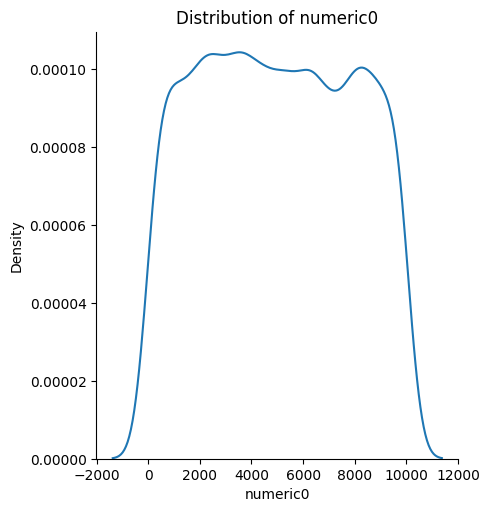

In [23]:
sns.displot(clean_data, x="numeric0", kind='kde')
plt.title("Distribution of numeric0")
plt.show()

This feature is uniformly distributed among all data. <br> Now we will look at the in-class distributions

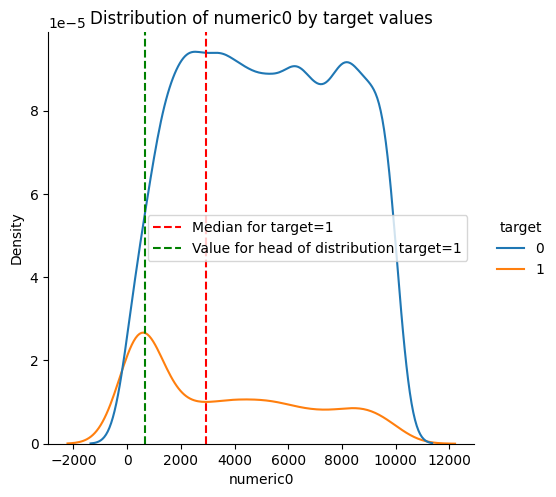

In [24]:
numeric0_1_median = clean_data.loc[clean_data.target == 1]['numeric0'].quantile(0.5)
target1_head_of_distribution = clean_data.loc[clean_data.target == 1]['numeric0'].quantile(0.25)

plot = sns.displot(clean_data, x="numeric0", hue="target", kind='kde')
plt.axvline(x = numeric0_1_median, c='r', linestyle='--', label='Median for target=1')
plt.axvline(x = target1_head_of_distribution, c='g', linestyle='--', label='Value for head of distribution target=1')
plt.legend(loc="right")
plt.title("Distribution of numeric0 by target values")
plt.show()

In [25]:
print(f"Median value of numeric0 for positive class is {numeric0_1_median}")

Median value of numeric0 for positive class is 2922.5


Our positive class has skewed distribution towards left side. 50% of positive class values are leaned into the 0-3000 range when numeric0 is uniformly distributed in 0-10000 range in general. <br> <br> Considering those facts we will binarize the values of numeric0 into 1000-size bins and treat this feature as categorical. <br> To consider the skewness of distribution we will implement the feature, which might lead us to better prediction performance - squared distance from the "bell" value of distribution

In [26]:
bins = [-np.inf] + [i for i in range(clean_data.numeric0.min(), clean_data.numeric0.max(), 1000)] + [np.inf]
clean_data["numeric0_bins"] = pd.cut(clean_data['numeric0'], bins)

In [27]:
clean_data.head()

,month,day_of_week,hour,numeric0,numeric1,categorical0,target,numeric0_bins
dttm,,,,,,,,
1970-01-01 13:13:57,1,3,13,7382,nan,c,0,"(7000.0, 8000.0]"
1970-01-02 23:37:45,1,4,23,192,6.0,b,0,"(0.0, 1000.0]"
1970-01-05 22:39:45,1,0,22,4291,nan,b,0,"(4000.0, 5000.0]"
1970-01-06 02:13:50,1,1,2,4226,5.0,a,0,"(4000.0, 5000.0]"
1970-01-06 22:57:37,1,1,22,9735,nan,c,0,"(9000.0, inf]"


## 3. Modelling

We will split our data based on time because of its nature

In [28]:
def split_data(data: pd.DataFrame, n_train_samples: int) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    data.sort_index(inplace=True)
    
    train_data = data[:n_train_samples]
    test_data = data[n_train_samples:]

    X_train = train_data.drop("target", axis=1)
    y_train = train_data["target"]
    X_test = test_data.drop("target", axis=1)
    y_test = test_data["target"]
    
    return X_train, X_test, y_train, y_test

In [29]:
train_size = int(clean_data.shape[0] * 0.8)

X_train, X_test, y_train, y_test = split_data(data=clean_data, n_train_samples=train_size)

At this part we have to complete feature generation part <br>
1. Calculate derivative feature from numeric0 (as discussed before)
2. Encode categorical features

In [30]:
train_data = pd.merge(X_train, y_train, how='left', left_index=True, right_index=True)
target1_head_of_distribution = train_data.loc[train_data.target == 1]['numeric0'].quantile(0.25)
categorical_features = ['month', 'day_of_week', 'hour', 'numeric1', 'categorical0', 'numeric0_bins']


def distance_from_bell(data: pd.Series, scaler: MinMaxScaler = None) -> (pd.Series, MinMaxScaler):
    dist = ((data - target1_head_of_distribution)**2).values.reshape(-1, 1)
    if not scaler:
        scaler = MinMaxScaler()
        dist_scaled = scaler.fit_transform(dist)
    else:
        dist_scaled = scaler.transform(dist)
    return pd.Series(dist_scaled.flatten(), index=data.index), scaler


def encode_categorial(data: pd.DataFrame, 
                      categories_names: list, enc: OneHotEncoder = None) -> (pd.DataFrame, OneHotEncoder):
    if not enc:
        enc = OneHotEncoder(drop='first')
        encoded_raw = enc.fit_transform(data[categories_names]).toarray()
    else:
        encoded_raw = enc.transform(data[categories_names]).toarray()
    encoded_df = pd.DataFrame(encoded_raw, 
                              columns=enc.get_feature_names_out(categories_names), 
                              index=data.index)
    return encoded_df, enc


def calculate_features(train: pd.DataFrame, test: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    train_dfm_scaled, scaler = distance_from_bell(data=train["numeric0"])
    test_dfm_scaled, _ = distance_from_bell(data=test["numeric0"], scaler=scaler)
    train = train.merge(train_dfm_scaled.rename("dfm_scaled"), 
                        left_index=True, right_index=True).drop(["numeric0"], axis=1)
    test = test.merge(test_dfm_scaled.rename("dfm_scaled"), 
                      left_index=True, right_index=True).drop(["numeric0"], axis=1)
    
    encoded_features_train, encoder = encode_categorial(data=train, categories_names=categorical_features)
    encoded_features_test, _ = encode_categorial(data=test, categories_names=categorical_features, enc=encoder)
    train = pd.merge(train, encoded_features_train, how='left', 
                       left_index=True, right_index=True).drop(categorical_features, axis=1)
    test = pd.merge(test, encoded_features_test, how='left', 
                       left_index=True, right_index=True).drop(categorical_features, axis=1)
    
    assert train.shape[1] == test.shape[1]
    return train, test

In [31]:
X_train, X_test = calculate_features(train=X_train, test=X_test)

In [32]:
X_train.head()

,dfm_scaled,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,"numeric0_bins_(0.0, 1000.0]","numeric0_bins_(1000.0, 2000.0]","numeric0_bins_(2000.0, 3000.0]","numeric0_bins_(3000.0, 4000.0]","numeric0_bins_(4000.0, 5000.0]","numeric0_bins_(5000.0, 6000.0]","numeric0_bins_(6000.0, 7000.0]","numeric0_bins_(7000.0, 8000.0]","numeric0_bins_(8000.0, 9000.0]","numeric0_bins_(9000.0, inf]"
dttm,,,,,,,,,,,,,,,,,,,,,
1970-01-01 13:13:57,0.517065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1970-01-02 23:37:45,0.002814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-05 22:39:45,0.149873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1970-01-06 02:13:50,0.144518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1970-01-06 22:57:37,0.944311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
features = list(X_train.columns)

### 3.1 Baseline model

Firstly, we need to understand where we are in terms of performance quality. <br> That's why we need first simple model <br> Let's use logistic regression without any tuning

In [34]:
def train_and_score(model, xtrain, ytrain, xtest, ytest):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    
    precision, recall, fscore, _ = score(y_test, y_pred, average='binary')
    rocauc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('roc auc: {}'.format(rocauc))
    print('TP={}, FP={}, TN={}, FN={}'.format(tp, fp, tn, fn))
    
    return model

In [35]:
lr = LogisticRegression()
train_and_score(model=lr, xtrain=X_train[features].values, ytrain=y_train.values, 
                xtest=X_test[features].values, ytest=y_test)

precision: 0.9076923076923077
recall: 0.23412698412698413
fscore: 0.3722397476340694
roc auc: 0.6153472449239039
TP=59, FP=6, TN=1742, FN=193


LogisticRegression()

As we can see our baseline model rarely fails in predicting a negative label as a positive one (precision), but it makes a lot of mistakes when it misses a positive class (recall). <br>

Our dataset suffers from imbalanced classes. That might lead to poor model performance in predicting positive class. <br> 

Next steps:
1. Handle imbalanced classes issue and try baseline model again
2. Make better work in feature selection process
3. Try other models

## 4. Handle imbalanced classes

We will try several techniques to tackle imbalanced classes' problem <br>
1. Down-sampling
2. Up-sampling
3. Penalizing for incorrect prediction of minority class

### 4.1 Down-sampling

The goal of down-sampling is to reduce the number of majority class sample (target=0)

In [36]:
train_data = pd.merge(X_train, y_train, how="left", left_index=True, right_index=True)

train_majority = train_data.loc[train_data.target == 0]
train_minority = train_data.loc[train_data.target == 1]

majority_downsampled = resample(train_majority, 
                                replace=False,
                                n_samples=train_minority.shape[0],
                                random_state=1) 

train_downsampled = pd.concat([majority_downsampled, train_minority])

In [37]:
train_downsampled.target.value_counts()

0    1078
1    1078
Name: target, dtype: int64

Check how down-sampling is solving our imbalanced classes' problem with baseline model

In [38]:
X_train = train_downsampled.drop("target", axis=1)
y_train = train_downsampled["target"]

In [39]:
lr = LogisticRegression()
train_and_score(model=lr, xtrain=X_train[features].values, ytrain=y_train.values, 
                xtest=X_test[features].values, ytest=y_test)

precision: 0.3256445047489824
recall: 0.9523809523809523
fscore: 0.48533872598584427
roc auc: 0.8340280047945952
TP=240, FP=497, TN=1251, FN=12


LogisticRegression()

With down-sampling our new model has opposite performance metrics. Now we have predicting well almost all true positive labels (high recall), but at the same time this model is making much more mistakes in predicting negative label as positive one (lower precision). But based on roc-auc score we can say, that our model now has much better generalization ability.

### 4.2 Up-sampling

Opposite idea to down-sampling - we will add more examples of our minority class to dataset

In [40]:
X_train, X_test, y_train, y_test = split_data(data=clean_data, n_train_samples=train_size)

In [41]:
X_train, X_test = calculate_features(train=X_train, test=X_test)

In [42]:
train_data = pd.merge(X_train, y_train, how="left", left_index=True, right_index=True)

train_majority = train_data.loc[train_data.target == 0]
train_minority = train_data.loc[train_data.target == 1]

minority_upsampled = resample(train_minority, 
                                replace=True,
                                n_samples=train_majority.shape[0],
                                random_state=1) 

train_upsampled = pd.concat([minority_upsampled, train_majority])

In [43]:
train_upsampled.target.value_counts()

1    6922
0    6922
Name: target, dtype: int64

Check how up-sampling is solving our imbalanced classes problem with baseline model

In [44]:
X_train = train_upsampled.drop("target", axis=1)
y_train = train_upsampled["target"]

In [45]:
lr = LogisticRegression()
train_and_score(model=lr, xtrain=X_train[features].values, ytrain=y_train.values, 
                xtest=X_test[features].values, ytest=y_test)

precision: 0.328
recall: 0.9761904761904762
fscore: 0.4910179640718563
roc auc: 0.8439304783698376
TP=246, FP=504, TN=1244, FN=6


LogisticRegression()

Up-sampling approach gave us slight improvement over down-sampling approach. But in general both approaches performed better than baseline model 

### 4.3 Penalizing model

We will try to use penalized learning algorithm that increase the cost of classification mistakes on the minority class

In [46]:
X_train, X_test, y_train, y_test = split_data(data=clean_data, n_train_samples=train_size)
X_train, X_test = calculate_features(train=X_train, test=X_test)

In [47]:
penal_model = SVC(class_weight='balanced')
train_and_score(model=penal_model, xtrain=X_train[features].values, ytrain=y_train.values, 
                xtest=X_test[features].values, ytest=y_test)

precision: 0.3275862068965517
recall: 0.9047619047619048
fscore: 0.48101265822784806
roc auc: 0.8185136754930804
TP=228, FP=468, TN=1280, FN=24


SVC(class_weight='balanced')

So penalizing model also does the trick, but it's not better than up-sampling technique.

## 5. Feature selection

Let's try to improve up-sampling model result and make some feature selection based on mutual information criteria.

### Repeat up-sampling procedure

In [48]:
X_train, X_test, y_train, y_test = split_data(data=clean_data, n_train_samples=train_size)
X_train, X_test = calculate_features(train=X_train, test=X_test)

In [49]:
train_data = pd.merge(X_train, y_train, how="left", left_index=True, right_index=True)

train_majority = train_data.loc[train_data.target == 0]
train_minority = train_data.loc[train_data.target == 1]

minority_upsampled = resample(train_minority, 
                                replace=True,
                                n_samples=train_majority.shape[0],
                                random_state=1) 

train_upsampled = pd.concat([minority_upsampled, train_majority])

In [50]:
X_train = train_upsampled.drop("target", axis=1)
y_train = train_upsampled["target"]

### Make feature selection based on mutual information criteria

We will use mutual information criteria, because we are dealing with categorical features mostly. <br>
Because of stochastic nature of the algorithm we will use bootstrapping technique and calculate average result

In [51]:
n_bootstrapers = 100

bootstrap_results = list()
for _ in range(n_bootstrapers):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    coef_dict = {feature: value for feature, value in zip(features, fs.scores_)}
    bootstrap_results.append(coef_dict)
    

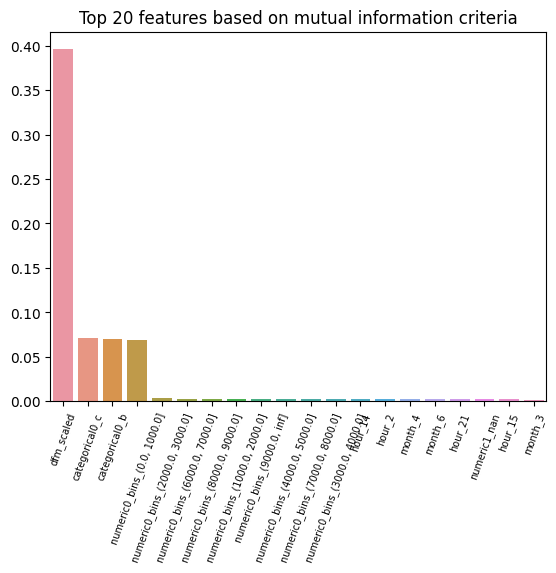

In [52]:
avg_coefs = pd.DataFrame(bootstrap_results).mean().sort_values(ascending=False)

sns.barplot(x=avg_coefs.head(20).index, y=avg_coefs.head(20).values)
plt.xticks(rotation=70, fontsize=7)
plt.title(f"Top 20 features based on mutual information criteria")
plt.show()

As expected, we can see that the most important features are distance from bell of target=1 numeric1 feature distribution and categorical0 feature. <br> <br> Let's see how the model will perform with reduced feature space 

In [53]:
reduced_features = list(avg_coefs.head(4).index)
reduced_features

['dfm_scaled',
 'categorical0_c',
 'categorical0_b',
 'numeric0_bins_(0.0, 1000.0]']

In [54]:
lr = LogisticRegression()
train_and_score(model=lr, xtrain=X_train[reduced_features].values, ytrain=y_train.values, 
                xtest=X_test[reduced_features].values, ytest=y_test)

precision: 0.328
recall: 0.9761904761904762
fscore: 0.4910179640718563
roc auc: 0.8439304783698376
TP=246, FP=504, TN=1244, FN=6


LogisticRegression()

In [55]:
lr.coef_

array([[-0.0697725 , -4.41914597, -4.44686388,  4.24187978]])

Feature space reducing didn't improve our model. <br> <br> Finally, let's try another family of algorithms - boosted trees - and look at its best solution in the optimal configuration

## 6. Boosted model

In [56]:
X_train, X_test, y_train, y_test = split_data(data=clean_data, n_train_samples=train_size)
X_train, X_test = calculate_features(train=X_train, test=X_test)

In [57]:
scale_coef = (y_train.shape[0] - y_train.sum()) / y_train.sum()

params  = {'scale_pos_weight': [scale_coef/2, scale_coef, scale_coef * 1.5],
           'depth'         : [4, 5, 6, 7, 8, 9, 10],
           'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2],
           'n_estimators'    : [100, 400, 800, 1000],
           'l2_leaf_reg': [2, 3, 4, 5, 6],
          }

In [58]:
params

{'scale_pos_weight': [3.2105751391465676,
  6.421150278293135,
  9.631725417439704],
 'depth': [4, 5, 6, 7, 8, 9, 10],
 'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2],
 'n_estimators': [100, 400, 800, 1000],
 'l2_leaf_reg': [2, 3, 4, 5, 6]}

In [59]:
cbc = CatBoostClassifier(verbose=False)
grid_cbc = GridSearchCV(estimator=cbc, param_grid=params, scoring="roc_auc", n_jobs=-1)

In [60]:
# # TAKES A COUPLE OF HOURS

# grid_cbc.fit(X_train[features].values, y_train)



# # SPOILER ALERT:
# # Results from Grid Search 

# #  The best estimator across ALL searched params:
# #  <catboost.core.CatBoostClassifier object at 0x7f7e51a6b2b0>

# #  The best score across ALL searched params:
# #  0.8678858603143335

# #  The best parameters across ALL searched params:
# #  {'depth': 9, 'l2_leaf_reg': 3, 'learning_rate': 0.2, 'n_estimators': 100, 'scale_pos_weight': 3.2105751391465676}

In [61]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid_cbc.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_cbc.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_cbc.best_params_)

In [62]:
catb = CatBoostClassifier(learning_rate=0.2, 
                          depth=9, 
                          l2_leaf_reg=3, 
                          n_estimators=100, 
                          scale_pos_weight=scale_coef/2, 
                          verbose=False)
train_and_score(model=catb, xtrain=X_train[reduced_features].values, ytrain=y_train.values, 
                xtest=X_test[reduced_features].values, ytest=y_test)

precision: 0.33907056798623064
recall: 0.7817460317460317
fscore: 0.47298919567827136
roc auc: 0.7810331989393774
TP=197, FP=384, TN=1364, FN=55


Long tree boosted model didn't give us a better model. We can conclude that from the current data with this set of features, we have squeezed out the maximum possible result

# 7. Conclusion

Our best model is the Logistic Regression model after the up-sampling. <br> <br> The model is extremly good at predicting positive class and rarely predicts them as negative ones - nearly 97% of accuracy in positive class predictions. <br> The only issue of this model is a slight sensitivity to the positive class, which leads to a not low, but generally acceptable quality of predicting the negative class - about 70% of accuracy. <br> 0.84 AUC-ROC value is a sign of a model with high generalization ability, especially on an anonymized dataset with a small number of features. <br> <br> Actually, interpretation of the results and further steps in analytics field is highly depends on business domain of the data. For example, if the cost of having mispredicted negative class is low, then we have a ready to go model!

# 8. Next steps

With more time for research what can we do next:
1. More feature engineering - ignoring the fact of sparse time-series we have, we can extract some times-series components, such as trend and seasonality
2. Different categorical encoding techniques (for example target frequencies calculation)
3. Other model families (ensemble modelling, NN approaches)
4. Collect more data